In [88]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

#Get Statistics of the video + Download Frames

In [89]:
import numpy as np
import cv2
import os

file_path = r'AVSS_E2.avi'
output_folder = r'C:/Frames/'  # Specify the output folder here

# Check if the output folder exists, create if not
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

cap = cv2.VideoCapture(file_path)

counter = 0
while cap.isOpened():
    # Read the frame
    ret, frame = cap.read()

    # Check if frame is successfully read
    if not ret:
        break
    
    # Save the frame
    FrameNo = output_folder + 'FrameNo' + str(counter) + '.png'
    cv2.imwrite(FrameNo, frame)

    # Show the frame
    cv2.imshow('Window', frame)
    
    # Check for 'q' key press to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    counter += 1

# Print video statistics
print("Frame Count   : ", cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Format        : ", cap.get(cv2.CAP_PROP_FORMAT))
print("Height        : ", cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Width         : ", cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("Mode          : ", cap.get(cv2.CAP_PROP_MODE))
print("Brightness    : ", cap.get(cv2.CAP_PROP_BRIGHTNESS))
print("Fourcc        : ", cap.get(cv2.CAP_PROP_FOURCC))
print("Contrast      : ", cap.get(cv2.CAP_PROP_CONTRAST))
print("FrameperSec   : ", cap.get(cv2.CAP_PROP_FPS))

# Calculate and print video duration
FrameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
FrameperSecond = cap.get(cv2.CAP_PROP_FPS)
DurationSecond = FrameCount / FrameperSecond if FrameperSecond > 0 else 0
print("FrameDuration : ", DurationSecond, "seconds")

# Release video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


Frame Count   :  4600.0
Format        :  0.0
Height        :  576.0
Width         :  720.0
Mode          :  0.0
Brightness    :  0.0
Fourcc        :  877677894.0
Contrast      :  0.0
FrameperSec   :  25.0
FrameDuration :  184.0 seconds


# Find the mask dimension to hide the train

Area of Interest :
 [[280  80]
 [  0 300]
 [  0 500]
 [700 500]
 [700  80]]


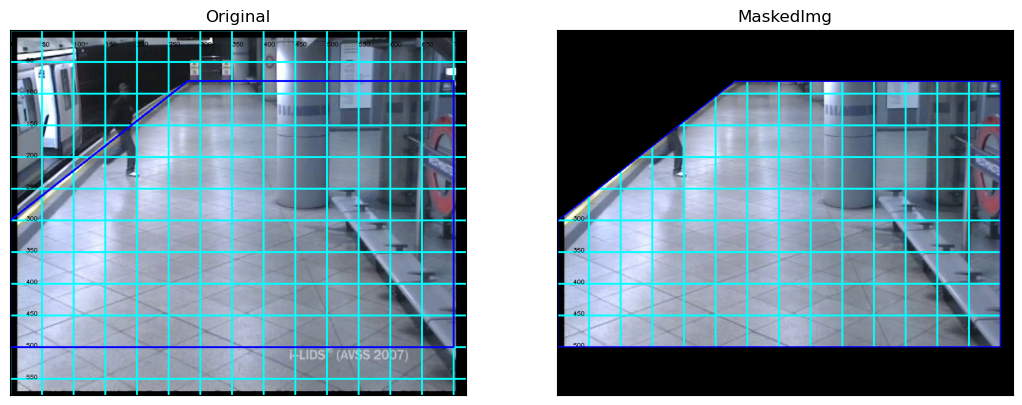

In [90]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

pathfile = r'FrameNo88_Train.png'

# Load image
img_original = cv2.imread(pathfile)
cv2.imshow('original', img_original)

# Draw Markers + Get width and Height + Break into 10 rows and columns
width = 720
height = 576

# Draw columns at 50 intervals, width step at 50, height from 0 to 576
col_interval = 50
for i in range(0, width, col_interval):
    cv2.line(img_original, (i, 0), (i, height), (255, 255, 0), 2)
    cv2.putText(img_original, '%s' % i, (i, int(col_interval / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), thickness=1)  # 0.6 is the fontScale
cv2.imshow('markers_col', img_original)

# Draw rows at 50 interval
row_interval = 50
for i in range(0, height, row_interval):
    cv2.line(img_original, (0, i), (width, i), (255, 255, 0), 2)
    cv2.putText(img_original, '%s' % i, (int(row_interval / 2), i), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), thickness=1)  # 0.6 is the fontScale

cv2.imshow('markers_col_row', img_original)

# Manually read the grid and mark down the x, y of the area of interest + Draw the polygon to confirm the mask location
# First mask - which is whole image black
mask = np.zeros(img_original.shape[:2], dtype="uint8")  # (576, 720, 3), take (576,720) same height and width as the image
cv2.imshow('mask', mask)

pts = np.array([[280, 80], [0, 300], [0, 500], [700, 500], [700, 80]], np.int32)

# Draw the polygon on the image
cv2.polylines(img_original, [pts], True, (255, 0, 0), thickness=2)
cv2.imshow('AreaOfInterest', img_original)

print("Area of Interest :\n", pts)

# Fill the polygon on the mask
cv2.fillPoly(mask, [pts], 255)
cv2.imshow('Masked', mask)

# Bitwise AND to apply the mask
masked = cv2.bitwise_and(img_original, img_original, mask=mask)
cv2.imshow('MaskedImg', masked)

# Show all images in Matplotlib
plt.figure(figsize=(20, 20))  # control size ; width and height in inches
plt.subplot(231), plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)), plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232), plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)), plt.title('MaskedImg'), plt.xticks([]), plt.yticks([])

cv2.waitKey(0)
cv2.destroyAllWindows()


# BackgroundSubtractorMOG

In [91]:
import numpy as np
import cv2
from collections import Counter, defaultdict

pathfile = r'FrameNo88_Train.png'

# Size the window first
cv2.namedWindow('CannyEdgeDet', cv2.WINDOW_NORMAL)  # user can resize window
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)  # user can resize window
cv2.namedWindow('Abandoned Object Detection', cv2.WINDOW_NORMAL)  # user can resize window
cv2.namedWindow('frame_masked', cv2.WINDOW_NORMAL)  # user can resize window
cv2.namedWindow('Morph_Close', cv2.WINDOW_NORMAL)  # user can resize window

# Load image
img_original = cv2.imread(pathfile)
cv2.imshow('original', img_original)

# Create Black Mask + Draw White Polygon on Black Mask
mask = np.zeros(img_original.shape[:2], dtype="uint8")  # (576, 720), same height and width as the image
pts = np.array([[280, 80], [0, 300], [0, 500], [650, 500], [650, 80]], np.int32)
cv2.fillPoly(mask, [pts], 255, 1)
cv2.imshow('Masked', mask)

# Location of video and first frame
file_path = r'AVSS_E2.avi'

# Read video
cap = cv2.VideoCapture(file_path)

# Initialize BackgroundSubtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

consecutiveframe = 20

track_temp = []
track_master = []
track_temp2 = []

top_contour_dict = defaultdict(int)
obj_detected_dict = defaultdict(int)

frameno = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frameno += 1
    cv2.putText(frame, f'Frameno:{frameno}', (400, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Apply Mask on frame
    fgmask = fgbg.apply(frame)
    fgmask_masked = cv2.bitwise_and(fgmask, fgmask, mask=mask)

    # Canny Edge Detection (these are broken lines along the boundary)
    edged = cv2.Canny(fgmask_masked, 30, 100)
    cv2.imshow('CannyEdgeDet', edged)

    kernel2 = np.ones((10, 10), np.uint8)
    thresh2 = cv2.morphologyEx(fgmask_masked, cv2.MORPH_CLOSE, kernel2, iterations=2)
    cv2.imshow('Morph_Close', thresh2)

    # Create a copy of the thresh to find contours
    cnts, _ = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mycnts = []  # every new frame, set to empty list
    for c in cnts:
        M = cv2.moments(c)
        if M['m00'] == 0:
            continue
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        if 100 <= cv2.contourArea(c) <= 20000:
            mycnts.append(c)
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f'C {cx},{cy},{cx+cy}', (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            sumcxcy = cx + cy
            track_temp.append([cx + cy, frameno])
            track_master.append([cx + cy, frameno])
            countuniqueframe = set(j for i, j in track_master)

            if len(countuniqueframe) > consecutiveframe:
                minframeno = min(j for i, j in track_master)
                for i, j in track_master:
                    if j != minframeno:
                        track_temp2.append([i, j])
                track_master = list(track_temp2)
                track_temp2 = []

            countcxcy = Counter(i for i, j in track_master)
            for i, j in countcxcy.items():
                if j >= consecutiveframe:
                    top_contour_dict[i] += 1

            if sumcxcy in top_contour_dict and top_contour_dict[sumcxcy] > 100:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
                cv2.putText(frame, 'CheckObject', (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                obj_detected_dict[sumcxcy] = frameno

    for i, j in obj_detected_dict.items():
        if frameno - obj_detected_dict[i] > 200:
            obj_detected_dict.pop(i)
            top_contour_dict[i] = 0

    cv2.polylines(frame, [pts], True, (255, 0, 0), thickness=2)
    cv2.imshow('Abandoned Object Detection', frame)
    cv2.imshow('frame', fgmask)
    cv2.imshow('frame_masked', fgmask_masked)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Print out the list of top contours and their count
top_contours = sorted(top_contour_dict, key=top_contour_dict.get, reverse=True)
for i in top_contours:
    print(i, top_contour_dict[i])
print("Contours recorded:", len(top_contours))

Contours recorded: 0


#Print key,value in Dictionary

#Additions in dictionary

#Print List to File

In [92]:
fileout_path=r"C:\Users\hnand\Downloads\tempcxcy.txt"

fileout = open(fileout_path,'w')

for cxcy,frameno in track_temp:
    fileout.write('%s;%s\n'%(cxcy,frameno))

fileout.close()


# Omit a value from the list + create a new list + copy new list to master list

# Apply Background Subtraction

* Read firstframe + BGR2GRAY + Gaussian Blur (ksize must be positive and odd) + show firstframe_blur


In [93]:
import numpy as np
import cv2
import os

# Location of video and first frame
file_path = r'AVSS_E2.avi'
firstframe_path = r'FrameNo88_Train.png'

# Initialize firstframe_blur to None
firstframe_blur = None

# Check if the first frame file exists
if not os.path.exists(firstframe_path):
    print(f"First frame file not found: {firstframe_path}")
else:
    # Read first frame + BGR2GRAY + Gaussian Blur (ksize must be positive and odd) + show firstframe_blur
    firstframe = cv2.imread(firstframe_path)
    if firstframe is None:
        print(f"Failed to read first frame from: {firstframe_path}")
    else:
        firstframe_gray = cv2.cvtColor(firstframe, cv2.COLOR_BGR2GRAY)
        firstframe_blur = cv2.GaussianBlur(firstframe_gray, (21, 21), 0)
        cv2.imshow('Firstframe_blur', firstframe_blur)

# Only proceed if the first frame was successfully processed
if firstframe_blur is not None:
    # Check if the video file exists
    if not os.path.exists(file_path):
        print(f"Video file not found: {file_path}")
    else:
        cap = cv2.VideoCapture(file_path)

        counter = 0
        frameno = 0

        while cap.isOpened():
            # Read the frame
            ret, frame = cap.read()

            # Check if the frame is read correctly
            if not ret:
                print(f"Failed to read frame {frameno}")
                break

            frameno += 1

            # Draw count line
            cv2.line(frame, (100, 150), (100, 400), (0, 255, 0), 2)

            # Frame + BGR2GRAY + Gaussian Blur + show frame_blur
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_blur = cv2.GaussianBlur(frame_gray, (21, 21), 0)
            cv2.imshow('frame_blur', frame_blur)

            # Absolute difference between firstframe_blur and frame_blur + show frame_difference
            frame_difference = cv2.absdiff(firstframe_blur, frame_blur)
            cv2.imshow('frame_diff', frame_difference)

            # Canny Edge Detection (these are broken lines along the boundary)
            edged = cv2.Canny(frame_difference, 30, 100)  # any gradient between 30 and 150 are considered edges
            cv2.imshow('Edge', edged)

            # Set up kernel for Morphological Transformation
            kernel = np.ones((15, 15), np.uint8)  # higher the kernel, eg (10,10), more will be eroded or dilated

            # Method 1: Dilate the Edges so that we can find contours
            thresh1 = cv2.dilate(edged, kernel, iterations=3)
            cv2.imshow('Dilate', thresh1)

            # Method 2: morphologyEx (CLOSED) Dilation followed by Erosion.
            kernel2 = np.ones((20, 20), np.uint8)  # higher the kernel, eg (10,10), more will be eroded or dilated
            thresh2 = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel2, iterations=2)
            cv2.imshow('Morph_Close', thresh2)

            # Create a copy of the thresh to find contours
            (cnts, _) = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            mycnts = []  # every new frame, set to empty list.
            # Loop over the contours
            for c in cnts:
                # Calculate Centroid using cv2.moments
                M = cv2.moments(c)
                if M['m00'] == 0:
                    continue
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])

                # Set contour criteria
                if cv2.contourArea(c) < 200 or cv2.contourArea(c) > 20000:
                    continue
                elif cv2.contourArea(c) > 5000 and cx < 70:
                    continue
                else:
                    mycnts.append(c)

                    # Compute the bounding box for the contour, draw it on the frame,
                    # and update the text
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(frame, 'C %s,%s' % (cx, cy), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

                    print(cv2.contourArea(c), cx, cy, frameno)

            cv2.putText(frame, '%s%s' % ('Objects :', len(mycnts)), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Show the frame
            cv2.imshow('Window', frame)

            # Control, press 'q' key to exit
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break

        # When everything is done, release cap
        cap.release()
        cv2.destroyAllWindows()
else:
    print("First frame could not be processed. Exiting.")


2453.5 181 185 1
2516.5 181 184 2
2461.0 182 184 3
2479.5 182 184 4
2392.5 182 185 5
2394.5 181 187 6
2456.0 182 185 7
2378.5 182 185 8
2425.5 181 184 9
2445.0 182 185 10
2454.5 181 184 11
2492.0 182 185 12
2450.0 181 185 13
2491.0 182 184 14
2521.0 182 185 15
2517.5 182 185 16
2492.0 182 184 17
2471.0 181 185 18
2454.5 181 185 19
2506.5 182 185 20
2529.0 181 184 21
2456.5 181 185 22
2503.0 181 185 23
4908.0 48 119 23
2476.5 181 184 24
2534.0 181 185 25
2520.0 181 185 26
2462.0 181 184 27
2535.5 181 184 28
2414.5 181 185 29
2549.5 181 186 30
2503.0 181 185 31
2428.0 181 185 32
2488.0 181 185 33
2483.5 182 185 34
2488.5 181 184 35
2529.0 181 184 36
2434.5 181 186 37
2496.5 181 185 38
2552.5 181 184 39
2411.0 181 186 40
2532.0 181 184 41
2531.0 181 184 42
2492.5 181 185 43
2529.0 181 184 44
2453.5 181 184 45
2460.0 181 185 46
2464.5 181 185 47
2402.0 181 186 48
2427.0 181 184 49
2436.0 181 185 50
2446.5 181 184 51
2395.5 181 185 52
2464.0 181 185 53
2445.0 181 185 54
2484.5 182 185 55
24

##Tracking of contours across multiple frames

* Create a list to store the Previous Cx and Current Cx ; comparecx = [previouscx, currentcx]
* if previouscx > width (line at eg 100) and currentcx < width ; then the person has cross the line at 100. Add to counter

* OBSERVE the video and see what happens when 1 person cross the line
* there will be multiple contours because it happens across multiple frames
* what we need is to count the contour that just crossed the line (at width = 100)
* So [P,C] ; P = previous cx while C = current cx
* P must be >100 ; before the line
* C must be <100 ; he has crossed the line

#Background Substraction + Counter

In [73]:
import numpy as np
import cv2

# location of video and first frame
file_path =r'AVSS_E2.avi'
firstframe_path =r'FrameNo88_Train.png'

#Read firstframe + BGR2GRAY + Gaussian Blur (ksize must be positive and odd) + show firstframe_blur
firstframe = cv2.imread(firstframe_path)
firstframe_gray = cv2.cvtColor(firstframe, cv2.COLOR_BGR2GRAY)
firstframe_blur = cv2.GaussianBlur(firstframe_gray,(21,21),0)
cv2.imshow('Firstframe_blur',firstframe_blur)


cap = cv2.VideoCapture(file_path)

counter = 0
frameno =0
comparecx=[0] # [previous cx, current cx] ; cross the line if the Pcx >100, Ccx<100
sumarea=0
PaxbyArea=0


Height = 200
Width = 200

while (cap.isOpened()):
    # read the frame ; 
    #Docstring:   read([, image]) -> retval, image
    ret, frame = cap.read()
    
        # have to check, else error on the last frame.
    if ret==0:
        break
    frameno = frameno + 1
    
    
    
    #----------------------
    #Draw count line
    #----------------------

    #Height = 400, Width = 600
    cv2.line(frame,(100,150),(100,400),(0,255,0),2)
    #cv2.line(frame,(150,150),(150,400),(0,255,0),2)
    
    
   
    
    
    
    #-------------------------------------------------
    #Frame + BGR2GRAY + Gaussian Blur + show frame_blur
    #-------------------------------------------------
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_blur = cv2.GaussianBlur(frame_gray,(21,21),0)
    cv2.imshow('frame_blur',frame_blur)
    
    #Absolute difference between firstframe_blur and frame_blur+ show frame_difference
    frame_difference = cv2.absdiff(firstframe_blur, frame_blur)
    cv2.imshow('frame_diff',frame_difference)
    
    
    #----------------------------------------------------------------
    #Canny Edge Detection (these are broken lines along the boundary)
    #----------------------------------------------------------------
    
    edged = cv2.Canny(frame_difference,30,50) #any gradient between 30 and 150 are considered edges
    cv2.imshow('CannyEdgeDetection',edged)
    
    # Set up kernel for Morphological Transformation
    kernel = np.ones((5,5),np.uint8) #higher the kernel, eg (10,10), more will be eroded or dilated
    
    # Choose either 1 or 2
    # Method 1: Dilate the Edges so that we can find contours
    thresh = cv2.dilate(edged, kernel, iterations=3)
    cv2.imshow('Dilate',thresh)
    
    # Method 2 : morphologyEx (CLOSED)Dilation followed by Erosion**. 
    # It is useful in **closing small holes inside the foreground** objects, or small black points on the object.
    #Docstring:   morphologyEx(src, op, kernel[, dst[, anchor[, iterations[, borderType[, borderValue]]]]]) -> dst
    kernel2 = np.ones((8,8),np.uint8) #higher the kernel, eg (10,10), more will be eroded or dilated
    thresh2 = cv2.morphologyEx(edged,cv2.MORPH_CLOSE, kernel2,iterations=3)
    cv2.imshow('Morph_Close', thresh2)  
    
    
    #----------------------------------------------------------------    
    #Create a copy of the thresh to find contours + set contour criteria + find contour
    #----------------------------------------------------------------
    
    (cnts, _) = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    #(cnts, _) = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.putText(frame,'%s'%('l'), (100,200),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
    #cv2.putText(frame,'l', (150,200),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
    
    # loop over the contours
    for i, c in enumerate(cnts):
        # if the contour is too small, ignore it
        
        M = cv2.moments(cnts[i])
        if M['m00'] == 0: 
            pass
        else:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        
        #----------------------------------------------------------------
        # SET contour criteria
        #----------------------------------------------------------------
        
        if cv2.contourArea(c) > 2000 and cx<150 and cy>150:

            # compute the bounding box for the contour, draw it on the frame,
            # and update the text
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
  


            # putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
            # org ; is the (x,y) location
            cv2.putText(frame,'C %s,%s'%(cx,cy), (cx,cy),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
            
            #OBSERVE the video and see what happens when 1 person cross the line
            # there will be multiple contours because it happens across multiple frames
            # what we need is to count the contour that just crossed the line (at width = 100)
            # So [P,C] ; P = previous cx while C = current cx
            # P must be >100 ; before the line
            # C must be <100 ; he has crossed the line
            
            print (cv2.contourArea(c), cx, cy, frameno, "-")
            
            #compare previous and current cx to see if they cross the line
            #print "Cx : ",comparecx
            comparecx.append(cx)
            if comparecx[0]>100 and comparecx[1]<100 : 
                counter = counter + 1
                sumarea = sumarea + cv2.contourArea(c) # sum the total area
                PaxbyArea = sumarea/6500 # calibrate this number to get accuracy
                print ("Pax ",counter, " - ",cv2.contourArea(c))
            comparecx.pop(0)
            
            


    cv2.putText(frame,'%s'%('ByCountline:'), (10,50),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
    cv2.putText(frame,'%s'%(counter), (10,80),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
    
    cv2.putText(frame,'%s'%('ByContourArea:'), (350,50),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
    cv2.putText(frame,'%.2f'%(PaxbyArea), (350,80),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)



    #show the frame
    #Docstring:   imshow(winname, mat) -> None
    cv2.imshow('Window',frame)



    #control, press 'q' key to exit
    # Min cv2.waitKey(integer = min at 1) ; video will be fast ; increase integer value to slow the video    
    if cv2.waitKey(40) & 0xFF == ord('q'):
        break


#when everything is done, release cap
cap.release()
cv2.destroyAllWindows()

#Actual count : 110
#ByCountline : 88
#ByCoutourArea : 109.75


# BackgroundSubtractorMOG2

* With Shadow

In [32]:
import numpy as np
import cv2

# location of video
file_path = r'AVSS_E2.avi'

# Open video capture
cap = cv2.VideoCapture(file_path)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Create Background Subtractor object
fgbg = cv2.createBackgroundSubtractorMOG2()

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        print("End of video or error reading frame.")
        break

    # Apply the background subtractor to get the foreground mask
    fgmask = fgbg.apply(frame)

    # Show the frame
    cv2.imshow('Frame', fgmask)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(40) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


In [53]:
import numpy as np
import cv2

file_path = r'AVSS_E2.avi'

cap = cv2.VideoCapture(file_path)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
fgbg = cv2.createBackgroundSubtractorKNN()  # Using KNN Background Subtractor as an alternative

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video or error reading frame.")
        break

    fgmask = fgbg.apply(frame)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    cv2.imshow('frame', fgmask)
    if cv2.waitKey(40) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()